The remaining 4 steps share a structure. They make a proposal model to explain the data. They show an example of the type of output the model creates. Then it says how its updating it parameters. Finally we show the process of fitting on the data.

In [12]:
using  Gen
using Plots

include("../step01-importing-data/utilities/read-files.jl")
DF = ReadDF("../../data/processed/DetrendedCov.csv")
xs = DF.Date
ys = DF.DetrendedN1
include("utilities/visualize.jl")

VizGenMCMC

This is our proposal model. It has 2 main parts. It has randomly generated parameters and some models from the xs input and the random parameters to the output. In this case it is modeling a simple linear model with some points flagged as outliers.

In [13]:
@gen function Linear_regression_with_outliers(xs::Vector{<:Real})
    # First, generate the core parameters of the model. 
    #These parameters are random because we will MCMC to find what parameters have higher probability
    slope ~ normal(0, 1000)# We use normal because we want a symetric distribution around zero that has all values have positive probability
    intercept ~ normal(0, 1000)#Same as why we use normal for slope
    noise ~ gamma(250, 250)#noise needs to be always positive and we want it to look vaguely normal so gamma makes sense
    prob_outlier ~ uniform(0, 1)#no bias in the % of outlier
    
    #Used to set a 1 to 1 correspondence to ys
    n = length(xs)
    # Next, we generate the container for the y values.
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 1e6)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

This is a helper function to let the visualization code know what the ys values look like without the outliers

In [14]:
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    Dict(
         :points => zip(xs, [trace[:data => i => :y] for i in 1:n]),
         :outliers => [trace[:data => i => :is_outlier] for i in 1:n],
         :xs => xs,
         :ys => [xs[i] * trace[:slope] + trace[:intercept] for i in 1:n])
end

serialize_trace (generic function with 1 method)

This is the visualize code we are using for the rest of this steps. it uses each steps serialize_trace function to find the info needed to graph the data along with the model.

In [15]:
function visualize_trace(trace::Dict; title="")

    #Graph points
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing) 
    scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)

    #Graph Line
    PLT = plot!(trace[:xs], trace[:ys], color = "black", lw = 3, label = nothing)


    #LogPlot
    scatter(map(first, inliers), log_modulus.(map(last, inliers)), markercolor="blue", label=nothing) 
    scatter!(map(first, outliers), log_modulus.(map(last, outliers)), markercolor="red", label=nothing)
    ExpPLT = plot!(trace[:xs], log_modulus.(trace[:ys]), color = "black", lw = 3, label = nothing)
    
    DuoPlot = plot(PLT,ExpPLT,title=title)
    return DuoPlot
end

visualize_trace (generic function with 1 method)

Before we look at the model on the actual data it makes sense to look at what a generic output of the data is.

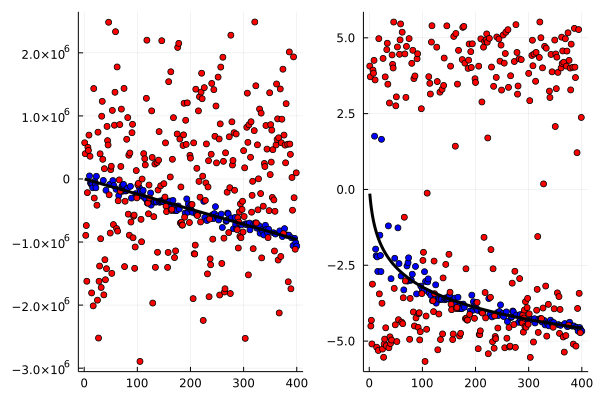

In [16]:
function VizGenModel(GenFunction::DynamicDSLFunction)
    ts = collect(range(1, stop=400, length=400))#create equaly spaced input values, simmilar in shape to the ones we use
    traces = simulate(GenFunction, (ts,));#Creating model with no constraints on parameters
    visualize_trace(serialize_trace(traces))
end
VizGenModel(Linear_regression_with_outliers)

What we want is for the code to find the best set of random parameters for the data. We do this by setting the output of the model to what our code has as the outputs. Then we can use Markov chain Monte Carlo to locate the best set of parameters.

In [18]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;
observations = make_constraints(ys);

ts = collect(range(1, stop=400, length=400))#create equaly spaced input values, simmilar in shape to the ones we use
    traces = simulate(Linear_regression_with_outliers, (ts,));
    typeof(traces)

UndefVarError: UndefVarError: GenFunction not defined

This function is what we use to tell the Markov chain Monte Carlo how to function. We update the parameters using the Metropolis Hasting algorithm in order from high level random variable down to low level random variable

In [8]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

We need to plot the data and prediction model to visualize what we have. We try to keep it concise and effective so made it to be only 50 iterations.

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_KBrWxHsmA9.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\rDbWY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_KBrWxHsmA9.gif")
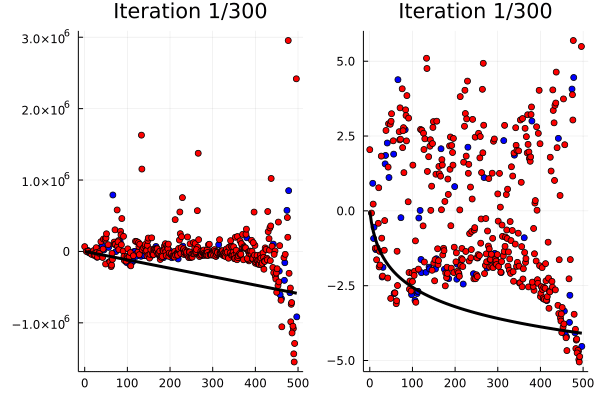

In [9]:
function VizGenMCMC(GenFunction::DynamicDSLFunction,xs,observations::DynamicChoiceMap,updateTrace::Function, NumFrame::Int64)
    t, = generate(GenFunction, (xs,), observations)#Create initial set of parameters to iterate on
    viz = @animate for i in 1:NumFrame
        t = updateTrace(t)
        visualize_trace(serialize_trace(t); title="Iteration $i/$NumFrame")
    end;
    gif(viz)
end
VizGenMCMC(Linear_regression_with_outliers, xs, observations,block_resimulation_update,300)